<a href="https://colab.research.google.com/github/Emma-Ok/Phishing-Detection-ML/blob/alc4dev/ModelsWithAllSamples/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install optuna

In [35]:
# Random Forest para Detección de Phishing
import numpy as np
import pandas as pd
import optuna
from optuna.samplers import TPESampler, RandomSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV, 
    StratifiedKFold,
    cross_val_score
)
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    matthews_corrcoef
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
from scipy import stats as st
warnings.filterwarnings('ignore')
# Carga directa desde GitHub
url = "https://raw.githubusercontent.com/Emma-Ok/Phishing-Detection-ML/main/Phishing_Legitimate_full.csv"
df = pd.read_csv(url)
df = df.drop(columns=['id'])

# Separar X e y
X = df.drop(columns=['CLASS_LABEL'])
y = df['CLASS_LABEL']

print(f"Forma del dataset: {X.shape}")
print(f"Distribución de clases: {Counter(y)}")


# 80 20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)


print(f"Entrenamiento: {X_train.shape[0]} muestras")
print(f"Prueba: {X_test.shape[0]} muestras")


Forma del dataset: (10000, 48)
Distribución de clases: Counter({1: 5000, 0: 5000})
Entrenamiento: 8000 muestras
Prueba: 2000 muestras


In [10]:
def get_rf_objective(X, y, cv=5, scoring='f1'):
    """
    Retorna una función objetivo para optimizar hiperparámetros de RandomForest con Optuna.
    
    Parámetros:
    - X: Features del dataset.
    - y: Etiquetas del dataset.
    - cv: Número de particiones para validación cruzada.
    - scoring: Métrica a optimizar ('accuracy', 'roc_auc', etc.).

    Retorna:
    - Función objetivo compatible con optuna.
    """
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 100),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'random_state': 42,
            'n_jobs': -1
        }

        clf = RandomForestClassifier(**params)
        scores = cross_val_score(clf, X, y, cv=cv, scoring=scoring)
        # Guardar información adicional en el trial
        trial.set_user_attr("cv_scores", scores.tolist())
        return scores.mean()

    return objective


In [41]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
objective = get_rf_objective(X=X_train_scaled, y=y_train, cv=cv_strategy)

study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42, n_startup_trials=10, multivariate=True, group=True))
study.optimize(objective, n_trials=100, timeout=3600, show_progress_bar=True)


[I 2025-07-08 01:12:36,001] A new study created in memory with name: no-name-77270d61-e399-43a7-8067-09e23f943fee


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-08 01:12:37,909] Trial 0 finished with value: 0.9705167432789871 and parameters: {'n_estimators': 144, 'max_depth': 96, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.9705167432789871.
[I 2025-07-08 01:12:40,402] Trial 1 finished with value: 0.9683738825709505 and parameters: {'n_estimators': 200, 'max_depth': 72, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.9705167432789871.
[I 2025-07-08 01:12:42,174] Trial 2 finished with value: 0.9760127577381594 and parameters: {'n_estimators': 126, 'max_depth': 54, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 0.9760127577381594.
[I 2025-07-08 01:12:44,713] Trial 3 finished with value: 0.9686141866683433 and parameters: {'n_estimators': 164, 'max_depth': 79, 'min_samples_split': 5, 'min_samples_leaf': 11, 'max

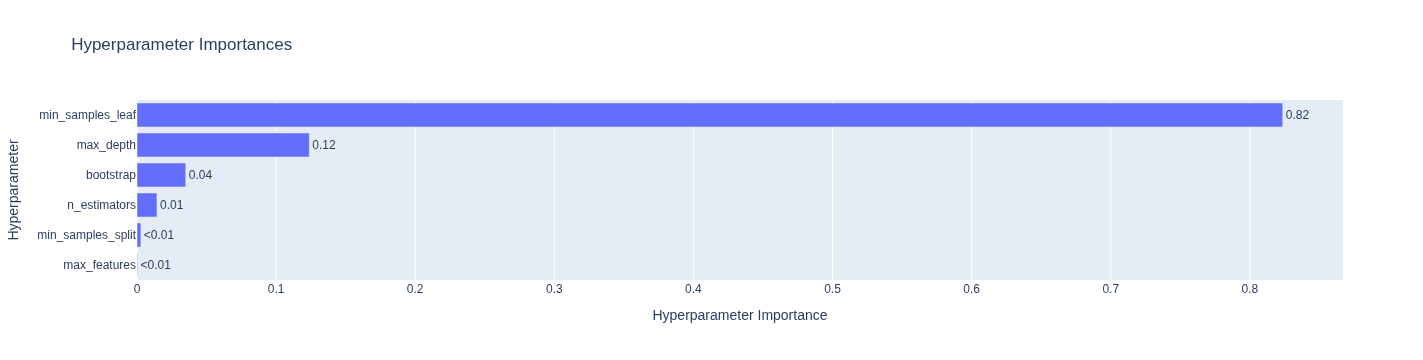

In [42]:
optuna.visualization.plot_param_importances(study)

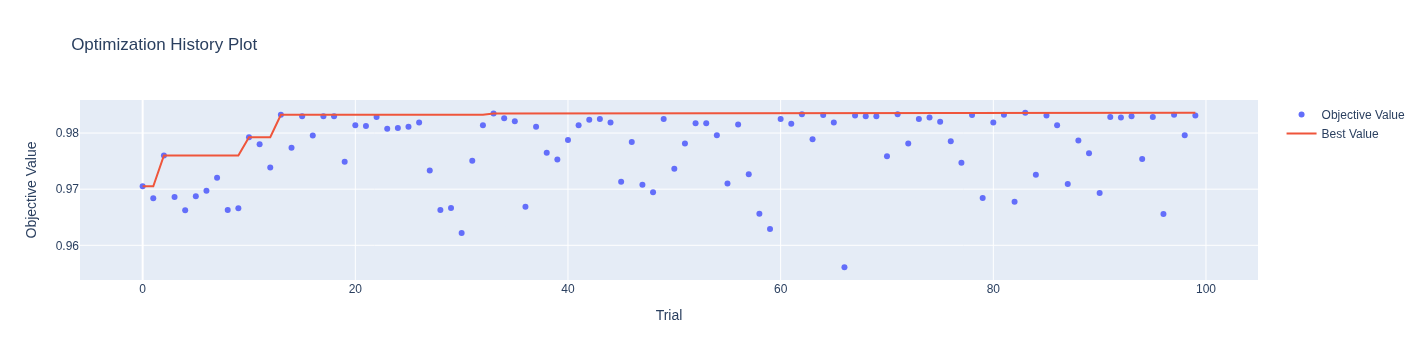

In [43]:
optuna.visualization.plot_optimization_history(study)

In [44]:
best_params = study.best_params
best_score = study.best_value

print(f"\n✅ Mejores hiperparámetros encontrados:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\n📈 Mejor F1-Score en validación cruzada: {best_score:.4f}")
best_trial = study.best_trial
scores = np.array(best_trial.user_attrs["cv_scores"])

mean_score = np.mean(scores)
sem = st.sem(scores)  # error estándar
ci = st.t.interval(0.95, len(scores)-1, loc=mean_score, scale=sem)

print(f"Accuracy promedio: {mean_score:.3f}")
print(f"SEM: {sem:.3f}")
print(f"IC 95%: ({ci[0]:.3f}, {ci[1]:.3f})")


✅ Mejores hiperparámetros encontrados:
  n_estimators: 295
  max_depth: 52
  min_samples_split: 3
  min_samples_leaf: 1
  max_features: sqrt
  bootstrap: False

📈 Mejor F1-Score en validación cruzada: 0.9836
Accuracy promedio: 0.984
SEM: 0.001
IC 95%: (0.980, 0.987)


In [45]:
# Función para calcular las métricas de evaluación
def calculate_metrics(y_true, y_pred, y_proba, set_name):
    
    print(f"\n=== MÉTRICAS - {set_name.upper()} ===")
    
    # Métricas principales
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_proba)
    
    # Métricas complementarias
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    print(f"Accuracy (Exactitud):     {accuracy:.4f}")
    print(f"Precision (Precisión):    {precision:.4f}")
    print(f"Recall (Sensibilidad):    {recall:.4f}")
    print(f"F1-Score:                 {f1:.4f}")
    print(f"AUC-ROC:                  {auc_roc:.4f}")
    print(f"Specificity (Especific.): {specificity:.4f}")
    print(f"MCC:                      {mcc:.4f}")
    
    return {
        'accuracy': accuracy, 'precision': precision, 'recall': recall,
        'f1_score': f1, 'auc_roc': auc_roc, 'specificity': specificity,
        'mcc': mcc
    }

In [48]:
# MODELO FINAL Y EVALUACIÓN
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)


# Entrena modelo final
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X_train_scaled, y_train)

# Predicciones en conjunto de prueba
y_test_pred = best_rf.predict(X_test_scaled)
y_test_proba = best_rf.predict_proba(X_test_scaled)[:, 1]

# Evaluación en prueba
calculate_metrics(y_test, y_test_pred, y_test_proba, "Prueba")
print(f"\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Legítimo', 'Phishing']))


=== MÉTRICAS - PRUEBA ===
Accuracy (Exactitud):     0.9865
Precision (Precisión):    0.9880
Recall (Sensibilidad):    0.9850
F1-Score:                 0.9865
AUC-ROC:                  0.9990
Specificity (Especific.): 0.9880
MCC:                      0.9730

Classification Report (Test):
              precision    recall  f1-score   support

    Legítimo       0.99      0.99      0.99      1000
    Phishing       0.99      0.98      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



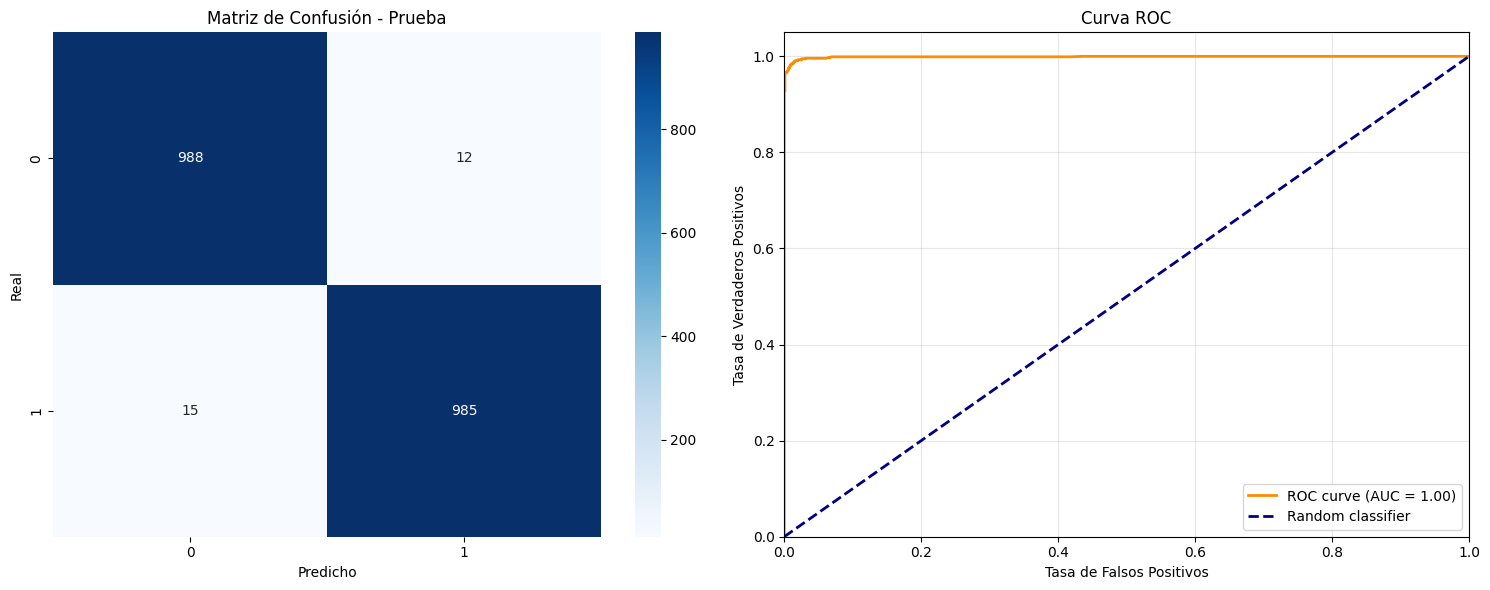

AUC-ROC: 0.9990
Mejor threshold: 0.4695


In [49]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Matriz de confusión - Prueba
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Matriz de Confusión - Prueba')
axes[0].set_xlabel('Predicho')
axes[0].set_ylabel('Real')

# Curva ROC
# Necesitas las probabilidades predichas en lugar de las clases predichas
# Asumiendo que tienes y_test_proba (probabilidades de la clase positiva)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa de Falsos Positivos')
axes[1].set_ylabel('Tasa de Verdaderos Positivos')
axes[1].set_title('Curva ROC')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Imprimir métricas adicionales
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"Mejor threshold: {thresholds[np.argmax(tpr - fpr)]:.4f}")

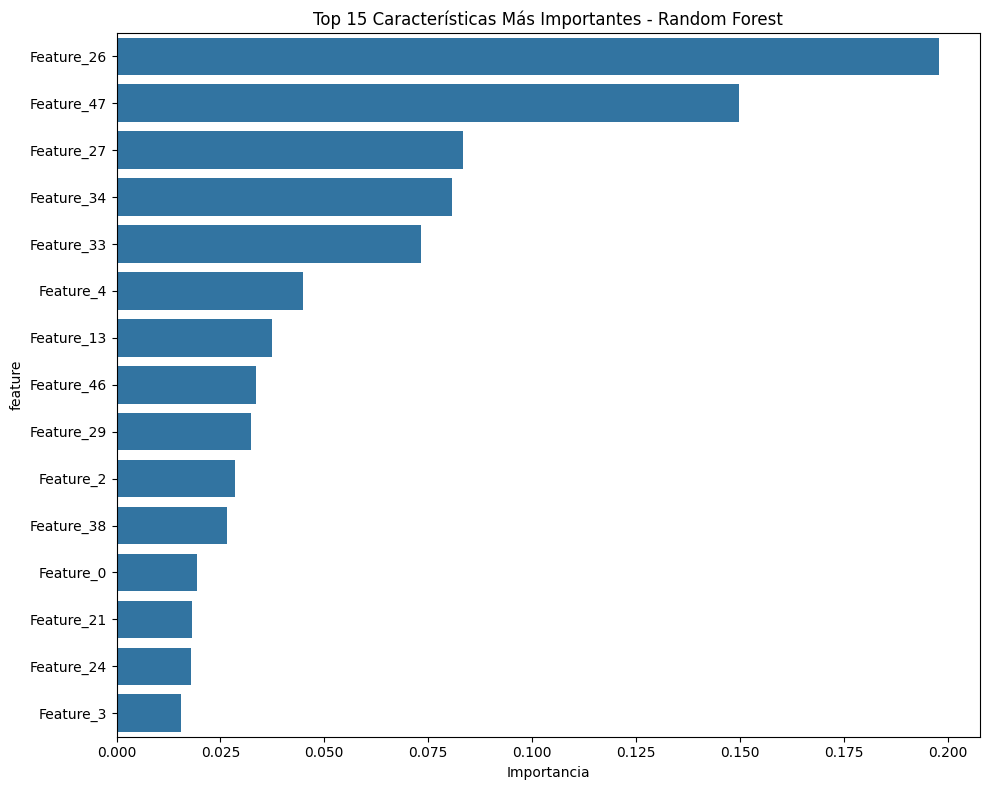

Top 10 Características:
 1. Feature_26: 0.1979
 2. Feature_47: 0.1499
 3. Feature_27: 0.0834
 4. Feature_34: 0.0807
 5. Feature_33: 0.0733
 6. Feature_4: 0.0450
 7. Feature_13: 0.0374
 8. Feature_46: 0.0335
 9. Feature_29: 0.0323
10. Feature_2: 0.0284


In [50]:
# IMPORTANCIA DE CARACTERÍSTICAS

# Obtener importancias
feature_importance = best_rf.feature_importances_
feature_names = [f'Feature_{i}' for i in range(len(feature_importance))]

# Crear DataFrame para visualización
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Visualizar top 15 características más importantes
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(15), x='importance', y='feature')
plt.title('Top 15 Características Más Importantes - Random Forest')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

print("Top 10 Características:")
for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['importance']:.4f}")
